## 1. Introduction

Twitter and Reddit are two social networks. They work different. However, in both, users can write and post text messages. That is why some people use them to express their opinion when there is some important present topic of general interest.

What we want to do is to build a classifier to know automatically if some text post expresses a negative opinion, a positive opinion or a neutral opinion of any topic. To do that, we will use two datasets from Kaggle, which can be found in <a href="https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset">Twitter and Reddit Sentimental analysis Dataset</a>. Here, there are messages of *Narendra Modi and Other Leaders as well as Peoples Opinion Towards the Next Prime Minister of The Nation ( In Context with General Elections Held In India - 2019).* Nevertheless, we want a general model to classify other types of messages, not only from Reddit and Twitter, and texts from other topics too.

One of those datasets has text posts of Reddit, each of them labeled with three possible numbers: -1, 0 or 1. The label is -1 if a negative sentiment is expressed, 0 if a neutral sentiment is expressed and 1 if a positive sentiment is expressed. The other datset is formed by tweets from Twitter, labeled the same way as Reddit's.

First, we will clean and prepare data to do some initial analyisis. Then, we will build the best model to classify and, at the end, we will check if our classifier works and we will do some extra analysis post classification.

### Dependencies

For this project, it is necessary to have installed those libraries:
* **Pandas** and **Numpy**: to treat easily our data.
* **MatplotLib**, **Seaborn** and **WordCloud**: to visualitze our data plotting some graphics.
* **SkLearn** and **XGBoost**: to build and analyze our classifiers.
* **Time**: to calculate time elapsed in train our models.
* **joblib** and **dill**: to save models and function which will be used in extra files.

In [95]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Model's imports
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc, confusion_matrix

# NLP's imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Extra imports
import joblib
import dill

## 2. Data

Before start analysing and making models, we need to read our data and undestand it. We will also clean our data, to have it prepared.

As we said before, in our case we have two datasets. The first one is made of Reddit comments, and the other one is made of tweets of Twitter. In each dataset, there is a label associated to each comment or tweet, (-1, 0 or 1).

It will be usefull to combine both datasets into one dataframe, but we will keep previous datasets.

In [2]:
# Load both datasets

# Load Reddit data
reddit_data = pd.read_csv('reddit_Data.csv')
reddit_data.rename(columns = {'clean_comment': 'text'}, inplace = True)

# Load Twitter data
twitter_data = pd.read_csv('Twitter_Data.csv')
twitter_data.rename(columns = {'clean_text': 'text'}, inplace = True)

# Combine both dataframes into one dataframe: data
data = pd.concat([reddit_data, twitter_data], ignore_index = True)

In [3]:
# Check dataset's shapes
print('Reddit dataset has', reddit_data.shape[0], 'rows.')
print('Twitter dataset has', twitter_data.shape[0], 'rows.')
print('Combined dataset has', data.shape[0], 'rows, which is', reddit_data.shape[0], '+', str(twitter_data.shape[0]) + '.')

Reddit dataset has 37249 rows.
Twitter dataset has 162980 rows.
Combined dataset has 200229 rows, which is 37249 + 162980.


In [4]:
reddit_data.isna().sum()

text        100
category      0
dtype: int64

In [5]:
twitter_data.isna().sum()

text        4
category    7
dtype: int64

In [6]:
data.isna().sum()

text        104
category      7
dtype: int64

There are 100 null values of text in Reddit dataset and 0 null values in category.

There are 4 null values of text in Reddit dataset and 7 null values in category.

We will just drop rows which have null elements and we will check again dataset's number of rows and number of null values, to ensure all has been done correctly.

In [7]:
reddit_data.dropna(axis = 0, inplace = True)
twitter_data.dropna(axis = 0, inplace = True)
data.dropna(axis = 0, inplace = True)

In [8]:
# Check dataset's shapes
print('Reddit dataset has', reddit_data.shape[0], 'rows.')
print('Twitter dataset has', twitter_data.shape[0], 'rows.')
print('Combined dataset has', data.shape[0], 'rows, which is', reddit_data.shape[0], '+', str(twitter_data.shape[0]) + '.')

Reddit dataset has 37149 rows.
Twitter dataset has 162969 rows.
Combined dataset has 200118 rows, which is 37149 + 162969.


In [9]:
reddit_data.isna().sum()

text        0
category    0
dtype: int64

In [10]:
twitter_data.isna().sum()

text        0
category    0
dtype: int64

In [11]:
data.isna().sum()

text        0
category    0
dtype: int64

In [12]:
# To reset dataset's indices (they have been damaged due the dropping)
data = data.reset_index()

Now, let us take a look at our datasets. Then, we will start analyzing our datasets.

In [13]:
reddit_data.head()

,text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [14]:
twitter_data.head()

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [15]:
data.head()

,index,text,category
0,0,family mormon have never tried explain them t...,1.0
1,1,buddhism has very much lot compatible with chr...,1.0
2,2,seriously don say thing first all they won get...,-1.0
3,3,what you have learned yours and only yours wha...,0.0
4,4,for your own benefit you may want read living ...,1.0


## 3. Data analysis

First, it will be interesting to see how many messages are labeled which each label in each dataset.

In [16]:
# Function to plot bar graphics with three labels (-1, 0 and 1) for a general
# dataset

def plot_label_bar_graphics(dataset):
    fig , ax = plt.subplots(figsize = (10,10))
    ax = dataset['category'].value_counts().plot(kind = 'bar')

    plt.xticks(rotation = 0, size = 14)
    plt.yticks(size = 14, color = 'white')
    plt.title('Distribution of Sentiment', size = 20)

    ax.annotate(text = dataset['category'].value_counts().values[0], xy = (-0.13, dataset['category'].value_counts().values[0]), size = 18)
    ax.annotate(text = dataset['category'].value_counts().values[1], xy = (0.87, dataset['category'].value_counts().values[1]), size = 18)
    ax.annotate(text = dataset['category'].value_counts().values[2], xy = (1.87, dataset['category'].value_counts().values[2]), size = 18)

    plt.show()

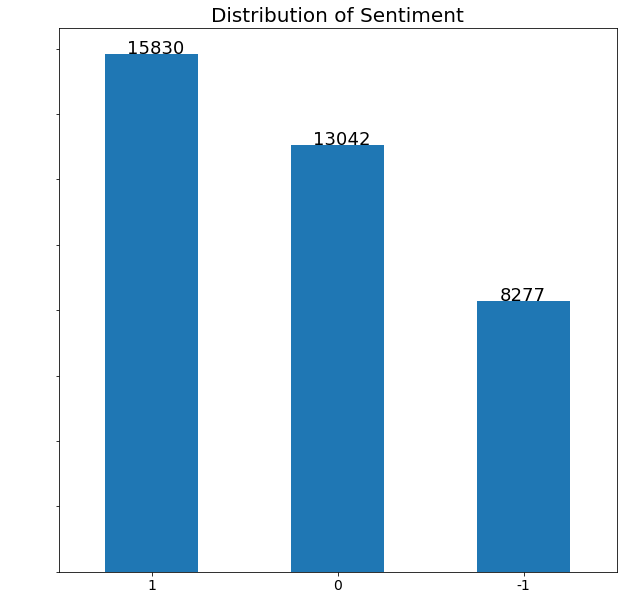

In [17]:
# Plot of bar graph of number of messages for each label in Reddit dataset

plot_label_bar_graphics(reddit_data)

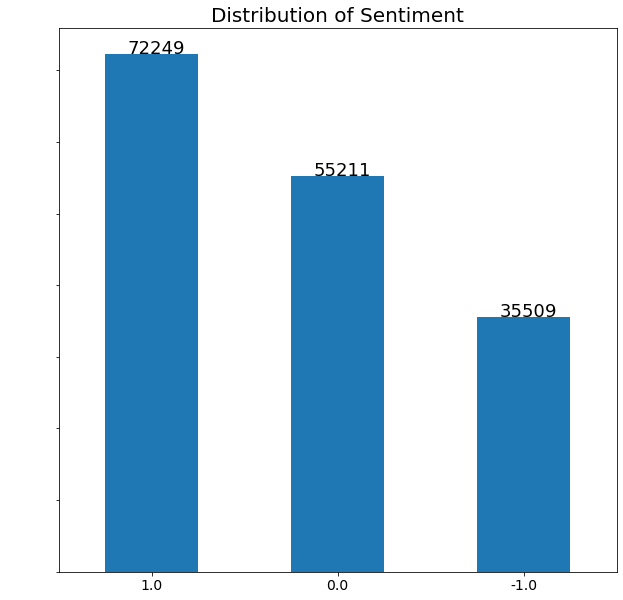

In [18]:
# Plot of bar graph of number of messages for each label in Twitter dataset

plot_label_bar_graphics(twitter_data)

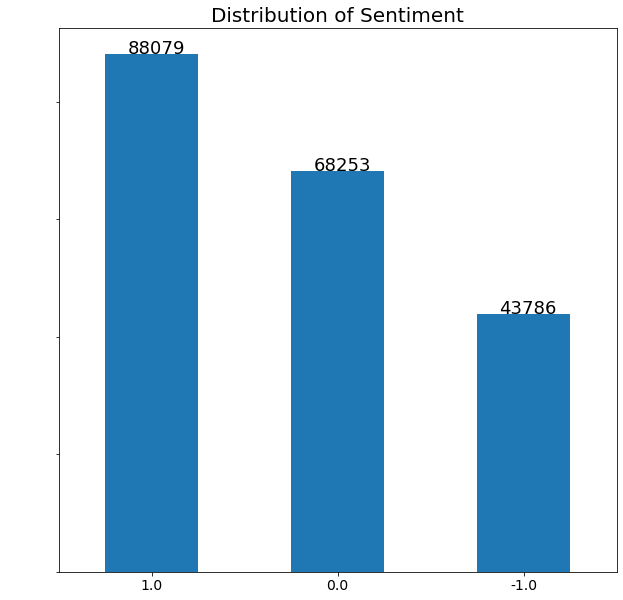

In [19]:
# Plot of bar graph of number of messages for each label in combined dataset

plot_label_bar_graphics(data)

As we can see, there are more samples from positive sentiments and less from negative sentiments. The number of neutral sentiment's samples is between positive and negative ones.

To visualize data, it will be usefull to do a word cloud of the combined dataset, one for all samples and three for words of messages of each label.

In [20]:
# Function to plot the word cloud of a general dataset

def plot_wordcloud(dataset):
    # Create word cloud from joining all messages
    wordcloud = WordCloud().generate(' '.join(dataset['text']))
    # Generate plot
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

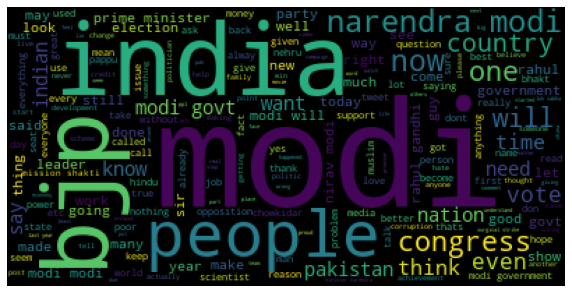

In [21]:
# Plot of the word cloud of all data

plot_wordcloud(data)

In [22]:
# Specific dataframes based on label

negative_data = data.loc[data['category'] == -1]
neutral_data = data.loc[data['category'] == 0]
positive_data = data.loc[data['category'] == 1]

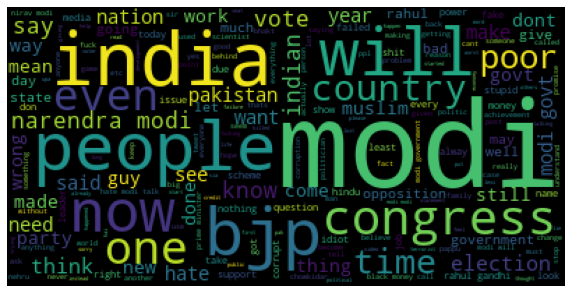

In [23]:
# Plot of the word cloud of all data

plot_wordcloud(negative_data)

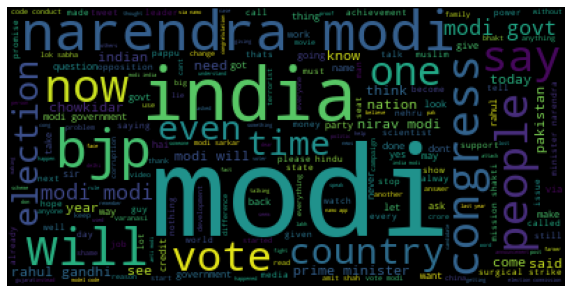

In [24]:
# Plot of the word cloud of all data

plot_wordcloud(neutral_data)

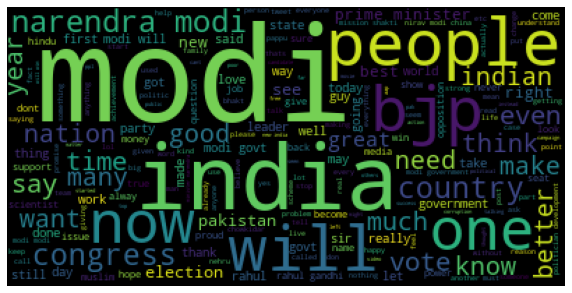

In [25]:
# Plot of the word cloud of all data

plot_wordcloud(positive_data)

With those word clouds, we can see which words appear the most. In general, those words are, for example, "modi", "india", "people", "bjp", etc. Nevertheless, those words may not be useful to classify by label, because we can observe that they appear in large quantity in messages of three labels. We want words that make us confirm or reject the belonging to one label.

To do that, we need first to choose a model to classify texts into the three labels.

## 4. Building the classifier

### 4.1 TF-IDF matrix

First of all, to do our clasiffication, we will use TF-IDF (Term Frequency-Inverse Document Frequency) matrix, which is used in natural language processing.

This matrix tells the importance of each word in classification. It is computed from TF matrix and IDF matrix. In fact, $TFIDF = TF \cdot IDF$.

The elements of TF matrix are the number of appearances of each word in each document (message). IDF matrix element's are:

$\log \frac{|D|}{1+|\{d \in D : t \in d\}|}$.

The numerator is the total number of documents, and $|\{d \in D : t \in d\}|$ is the number of documents where word $t$ appears.

This TF-IDF matrix allows us to train a model to classify.

To build TF-IDF matrix, we can use hashing vectorizer or count vectorizer. With hashing vectorizer, we can not obtain words from the TF-IDF matrix. Nevertheless, hashing vectorizer is faster than count vectorizer, and it is more recommended to big datasets. That's why we will use hashing vectorizer.

In [26]:
# Function to compute TF-IDF matrix of a dataset of texts

def compute_tfidf_matrix(text):
    # Create a Vectorizer Object using default parameters
    hash_vectorizer = HashingVectorizer()

    # Convert a collection of text documents to a matrix of token counts
    token_count_matrix = hash_vectorizer.fit_transform(text)

    # Create a tf_idf object using default parameters
    tf_idf_transformer = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 

    # Fit to the count matrix, then transform it to a normalized tf-idf representation
    tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)
    
    return tf_idf_matrix

### 4.2 Model selection

Once we can obtain easily the TF-IDF matrix, we will start selecting our model. We will try several models.

We will see that the only model that works well is LinearSVC. Some of the other models does not get fitted properly. They take too much long to get fitted or it gives nonsense scores or too bad scores. That's why those models, except KNN, are included in the code but they are commented.

Before testing our models, we need to compute our matrices and split our datasets into train and test. First, we will test our models with combined dataset.

In [27]:
# Get X and y from the Reddit dataset
X_reddit = compute_tfidf_matrix(reddit_data['text'])
y_reddit = reddit_data.category

#Split the data into train and test
X_train_reddit, X_test_reddit, y_train_reddit, y_test_reddit = train_test_split(X_reddit, y_reddit, test_size=0.1)

In [28]:
# Get X and y from the Twitter dataset
X_twitter = compute_tfidf_matrix(twitter_data['text'])
y_twitter = twitter_data.category

# Split the data into train and test
X_train_twitter, X_test_twitter, y_train_twitter, y_test_twitter = train_test_split(X_twitter, y_twitter, test_size=0.1)

In [29]:
# Get X and y from the combined dataset
X = compute_tfidf_matrix(data['text'])
y = data.category

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [87]:
# KNN

knn = KNeighborsClassifier()
t1 = time.time()
knn.fit(X_train, y_train)
t2 = time.time()
print(f"Accuracy: {knn.score(X_test, y_test) * 100:.3f}%", )
print('Time: ', int((t2-t1)*100)/100)

Accuracy: 40.566%
Time:  0.1


In [31]:
# SVC with polynomial kernel

"""""
psvc = SVC(kernel='poly')
psvc.fit(X_train, y_train)
print(f"Accuracy: {psvc.score(X_test, y_test) * 100:.3f}%", )
"""""

'""\npsvc = SVC(kernel=\'poly\')\npsvc.fit(X_train, y_train)\nprint(f"Accuracy: {psvc.score(X_test, y_test) * 100:.3f}%", )\n'

In [32]:
# Logistic regression

"""""
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(f"Accuracy: {lr.score(X_test, y_test) * 100:.3f}%", )
"""""

'""\nlr = LogisticRegression()\nlr.fit(X_train, y_train)\nprint(f"Accuracy: {lr.score(X_test, y_test) * 100:.3f}%", )\n'

In [33]:
# Random forest

"""""
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print(f"Accuracy: {rf.score(X_test, y_test) * 100:.3f}%", )
"""""

'""\nrf = RandomForestClassifier()\nrf.fit(X_train,y_train)\nprint(f"Accuracy: {rf.score(X_test, y_test) * 100:.3f}%", )\n'

In [34]:
# XG boost

"""""
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(f"Accuracy: {xgb.score(X_test, y_test) * 100:.3f}%", )
"""""

'""\nxgb = XGBClassifier()\nxgb.fit(X_train, y_train)\nprint(f"Accuracy: {xgb.score(X_test, y_test) * 100:.3f}%", )\n'

In [94]:
# Linear SVC

lsvc = LinearSVC()
t1 = time.time()
lsvc.fit(X_train, y_train)
t2 = time.time()
print(f"Accuracy: {lsvc.score(X_test, y_test) * 100:.3f}%", )
print('Time: ', int((t2-t1)*100)/100)

Accuracy: 94.633%
Time:  7.89


### 4.3 Hyperparametric search

Using linear SVC we have got a good accuracy. Nevertheless, we can optimize our model doing hyperparametric search. We can search the best parameter C to improve the accuracy. To do that, we will use grid search.

In [36]:
C_start, C_end, C_step = -3, 10, 1

# Generate grid search values for C
C_val = 2. ** np.arange(C_start, C_end + C_step, C_step)
lsvc_params = {'C': C_val}

In [37]:
# Hyperparametric search with 5 crossvalidation levels (cv=5)

lsvc_grid_search = LinearSVC()
grid_search = GridSearchCV(estimator=lsvc_grid_search, param_grid=lsvc_params,
                          cv = 5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'C': 1.0}

In [38]:
grid_search

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00, 2.000e+00, 4.000e+00,
       8.000e+00, 1.600e+01, 3.200e+01, 6.400e+01, 1.280e+02, 2.560e+02,
       5.120e+02, 1.024e+03])},
             verbose=2)

In [39]:
# See best C value and it's accuracy

best_grid = grid_search.best_estimator_
y = best_grid.predict(X_test)
grid_accuracy = metrics.accuracy_score(y_test, y)
print('The best value is C = ' + str(best_grid.C) + '.')
print('With C = ' + str(best_grid.C) + ' we obtain an accuracy of {:0.2f}%.'.format(grid_accuracy))

The best value is C = 1.0.
With C = 1.0 we obtain an accuracy of 0.95%.


As we have seen, the best value of C is 1, which is the default value, that is, the value that C has if we do not specify it. Our first model made with LinearSVC() class, was already made with C = 1. We will not need to set any C value because we know that the default value is the best one.

Finally, we will define a linear SVC with C = 1 as our best model.

In [40]:
classifier = lsvc

### 4.4 Permutating Twitter and Reddit datasets to train and test

Now we know which is the best model and it's best parameter, we will test to train this model only with Twitter dataset and only with Reddit dataset. Then, we will test each of them with test dataset of Twitter and Reddit.

In [41]:
# Train with Reddit dataset

reddit_lsvc = LinearSVC()
reddit_lsvc.fit(X_train_reddit, y_train_reddit)

LinearSVC()

In [42]:
# Train with Twitter dataset

twitter_lsvc = LinearSVC()
twitter_lsvc.fit(X_train_twitter, y_train_twitter)

LinearSVC()

In [43]:
# Accuracy of the model trained with Reddit dataset and tested with Reddit
# dataset

acc1 = reddit_lsvc.score(X_test_reddit, y_test_reddit)
print(f"Accuracy: {acc1 * 100:.3f}%", )

Accuracy: 89.475%


In [44]:
# Accuracy of the model trained with Reddit dataset and tested with Twitter
# dataset

acc2 = reddit_lsvc.score(X_test_twitter, y_test_twitter)
print(f"Accuracy: {acc2 * 100:.3f}%", )

Accuracy: 85.942%


In [45]:
# Accuracy of the model trained with Twitter dataset and tested with Reddit
# dataset

acc3 = twitter_lsvc.score(X_test_reddit, y_test_reddit)
print(f"Accuracy: {acc3 * 100:.3f}%", )

Accuracy: 93.217%


In [46]:
# Accuracy of the model trained with Twitter dataset and tested with Twitter
# dataset

acc4 = twitter_lsvc.score(X_test_twitter, y_test_twitter)
print(f"Accuracy: {acc4 * 100:.3f}%", )

Accuracy: 94.557%


In [47]:
# Results' matrix

matrix = np.array([[acc1, acc2], [acc3, acc4]])
df = pd.DataFrame(matrix, index=['Trained with Reddit','Trained with Twitter'], columns=['Tested with Reddit', 'Tested with Twitter'])
print('Accuracies obtained (in %):')
df.round(decimals=4)*100

Accuracies obtained (in %):


,Tested with Reddit,Tested with Twitter
Trained with Reddit,89.48,85.94
Trained with Twitter,93.22,94.56


Results make sense: accuracies are better when we test the model with the same dataset with which we have trained it. Furthermore, both models trained with Twitter dataset have best accuracies than Reddit ones. That is because Twitter dataset has more data than Reddit dataset: the first one has 162980 rows and the other one has 37249 rows.

## 5. Model testing

We have already selected a model which has an accuracy of approximately 94%. Now, we will see that it really works testing it with self-written messages using function classify.

First, we will classify six short messages, two for each label. Then, we will classify two messages more elaborated: one is from a complaint letter and the other one is from a congratulations letter. Obiously, the first one will have to be classified as a negative sentiment and, the second one, as a positive sentiment.

In [103]:
# Function that prints which sentiment is expressed in one message

def classify(message, classifier=classifier):
    text = pd.Series(message)
    hash_vectorizer = HashingVectorizer()
    token_count_matrix=hash_vectorizer.fit_transform(text)
    tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 
    tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)
    label = int(classifier.predict(tf_idf_matrix)[0])
    if label == -1:
        print('Negative sentiment')
    elif label == 1:
        print('Positive sentiment')
    else:
        print('Neutral sentiment')

In [104]:
# Examples of classification of short messages

# Negative sentiments
classify("Oh shit! That's disgusting!")
classify('Fuck the goverment, embrace anarchy.')
print()

# Neutral sentiments
classify('Have you done your homework?')
classify('fslajfldgdiufe hmeior qfewioaehui') # Means nothing
print()

# Positive sentiments
classify('I want you to know that I liked it so much')
classify("Donald Trump won the election, and that's fine")

Negative sentiment
Negative sentiment

Neutral sentiment
Neutral sentiment

Positive sentiment
Positive sentiment


In [50]:
# Examples of classification of more elaborated messages

# Complaint letter (negative sentiment)
classify('I sent you this letter of complaint because the last steel shipment does not match with our order from September 3th. On that date, we placed an order and paid for 75 hardened steel pipes, with 4 inches width and 15 feet long. Today, we received the goods and they have the wrong dimensions as they are 3 inches width instead of 4')

# Congratulations letter (positive sentiment)
classify("On behalf of myself and all the company, I am especially pleased to congratulate you on your recent nomination as president of the Association. In our opinion, the members' votes have not only made the regard for your own personal prestige clear but also they show the trust that we all hold in you. I hope soon to have the occasion to congratulate you in person and offer you my 100 per cent collaboration.")

Negative sentiment
Positive sentiment


We can observe that all messages have been well classified: our model works properly.

## 6. Extra analysis

We have already selected a model. Now, it is time to do some other analysis of the dataset as from our classifier.

### 6.1 Most important words to classify

When we did our first analysis, we did three word clouds to visualize which words appear the most, and we observed that they gave us few information about which words make us decide which label a message has.

There are three labels. In addition to classifying, given a message we can compute the probability that it belongs to each label. Now, we will compute those probabilities for each word in the dataset. That will give us an idea of which words are the most important when classifying. That is, for example, which words will tell us that a message will, very likely, be expressing a positive, a negative or a neutral sentiment.

In [51]:
# To compute probabilities. LinearSVC does not have predict_proba

clf = CalibratedClassifierCV(classifier)
clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC())

In [105]:
# Function that computes the probability (in an np.array) that a given message
# has each label (-1, 0 or 1)

def predict(message, clf=clf):
    text = pd.Series(message)
    hash_vectorizer = HashingVectorizer()
    token_count_matrix=hash_vectorizer.fit_transform(text)
    tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 
    tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)
    return clf.predict_proba(tf_idf_matrix)

In [53]:
# List of words that appear in the dataset with no repetition

# List of words
words = []
for m in data['text']:
    wl = m.split()
    for w in wl:
        words.append(w)
        
# Remove repeated words
words = np.array(pd.unique(words))

In [54]:
# Save in a dictionary all words with it's probabilities

probs_dict = dict({})
for i, w in enumerate(words):
    probs_dict[w] = predict(w)
    if i % 1000 == 0:
        print('Iteration ' + str(i) + '     ' + str(int(100*i/len(words))) + '% completed.')

Iteration 0     0% completed.
Iteration 1000     0% completed.
Iteration 2000     1% completed.
Iteration 3000     2% completed.
Iteration 4000     2% completed.
Iteration 5000     3% completed.
Iteration 6000     4% completed.
Iteration 7000     5% completed.
Iteration 8000     5% completed.
Iteration 9000     6% completed.
Iteration 10000     7% completed.
Iteration 11000     7% completed.
Iteration 12000     8% completed.
Iteration 13000     9% completed.
Iteration 14000     10% completed.
Iteration 15000     10% completed.
Iteration 16000     11% completed.
Iteration 17000     12% completed.
Iteration 18000     12% completed.
Iteration 19000     13% completed.
Iteration 20000     14% completed.
Iteration 21000     15% completed.
Iteration 22000     15% completed.
Iteration 23000     16% completed.
Iteration 24000     17% completed.
Iteration 25000     18% completed.
Iteration 26000     18% completed.
Iteration 27000     19% completed.
Iteration 28000     20% completed.
Iteration 29

In [55]:
probs_dict

{'family': array([[0.03863526, 0.8867214 , 0.07464334]]),
 'mormon': array([[0.02301993, 0.91114959, 0.06583047]]),
 'have': array([[0.02926191, 0.89274608, 0.07799201]]),
 'never': array([[0.09932543, 0.85798208, 0.04269248]]),
 'tried': array([[0.08415732, 0.89244494, 0.02339774]]),
 'explain': array([[0.03489754, 0.90572852, 0.05937394]]),
 'them': array([[0.03263455, 0.89710327, 0.07026218]]),
 'they': array([[0.02188065, 0.91257563, 0.06554372]]),
 'still': array([[0.03336921, 0.92768104, 0.03894975]]),
 'stare': array([[0.02300656, 0.9385401 , 0.03845334]]),
 'puzzled': array([[0.00985389, 0.94269601, 0.0474501 ]]),
 'from': array([[0.03553373, 0.8957045 , 0.06876177]]),
 'time': array([[0.02798664, 0.90817555, 0.06383781]]),
 'like': array([[0.02361911, 0.89964843, 0.07673245]]),
 'some': array([[0.04629488, 0.9082475 , 0.04545762]]),
 'kind': array([[8.63646453e-12, 8.83790633e-11, 1.00000000e+00]]),
 'strange': array([[9.62791543e-01, 2.58061336e-06, 3.72058760e-02]]),
 'creat

In [56]:
# Dictionaries splitted by label

dict_negative = dict({})
dict_neutral = dict({})
dict_positive = dict({})
for w in probs_dict:
    dict_negative[w] = probs_dict[w][0][0]
    dict_neutral[w] = probs_dict[w][0][1]
    dict_positive[w] = probs_dict[w][0][2]

In [57]:
# Order previous dictionaries

ordered_negative = {k: v for k, v in sorted(dict_negative.items(), key=lambda item: item[1], reverse=True)}
ordered_neutral = {k: v for k, v in sorted(dict_neutral.items(), key=lambda item: item[1], reverse=True)}
ordered_positive = {k: v for k, v in sorted(dict_positive.items(), key=lambda item: item[1], reverse=True)}

In [58]:
# Take first 50 words of each ordered dictionary

num_words = 50

negative_words = list(ordered_negative.keys())[:num_words]
neutral_words = list(ordered_neutral.keys())[:num_words]
positive_words = list(ordered_positive.keys())[:num_words]

negative_values = list(ordered_negative.values())[:num_words]
neutral_values = list(ordered_neutral.values())[:num_words]
positive_values = list(ordered_positive.values())[:num_words]

In [59]:
# Take first 10 words of each ordered dictionary which only have letters of
# the latin alphabet

num_words_only = 10

negative_words_only = [w for w in negative_words if w.isalpha()]
neutral_words_only = [w for w in neutral_words if w.isalpha()]
positive_words_only = [w for w in positive_words if w.isalpha()]

negative_words_only = negative_words_only[:num_words_only]
neutral_words_only = neutral_words_only[:num_words_only]
positive_words_only = positive_words_only[:num_words_only]

negative_values_only = [dict_negative[w] for w in negative_words_only]
neutral_values_only = [dict_neutral[w] for w in neutral_words_only]
positive_values_only = [dict_positive[w] for w in positive_words_only]

negative_ordered_dict = dict({k: v for k, v in zip(negative_words_only, negative_values_only)})
neutral_ordered_dict = dict({k: v for k, v in zip(neutral_words_only, neutral_values_only)})
positive_ordered_dict = dict({k: v for k, v in zip(positive_words_only, positive_values_only)})

In [60]:
negative_ordered_dict

{'hate': 0.999999999904016,
 'stupid': 0.9999999992918003,
 'failed': 0.9999999612879081,
 'poor': 0.9999998986454439,
 'bad': 0.9999998626827905,
 'fake': 0.9999998490479998,
 'macaroni': 0.9999998490479998,
 'bloody': 0.9999998440233702,
 'dangerous': 0.9999998432608826,
 'base': 0.9999998316040903}

In [61]:
neutral_ordered_dict

{'modi': 0.9956961531779973}

In [62]:
positive_ordered_dict

{'great': 0.9999999999999989,
 'best': 0.9999999999999973,
 'more': 0.9999999999999952,
 'rabbis': 0.9999999999999952,
 'own': 0.999999999999938,
 'proud': 0.999999999999875,
 'good': 0.9999999999993221,
 'many': 0.9999999999966661,
 'better': 0.9999999999951104,
 'win': 0.9999999999795213}

In [63]:
neutral_words

['modi',
 'modi’',
 '“modi',
 'modi”',
 'modi®',
 'modi\\',
 'modi…',
 '‘modi’',
 '‘modi',
 '“modi’',
 'modi❔❓',
 'modi—',
 'modi☺️',
 '“modi”',
 'modi،',
 'modi✌',
 '✅modi',
 'modi☺☺☺☺☺☺☺',
 '“——modi',
 'modi☠',
 'modi❤',
 '‘’modi',
 '✌✌modi',
 'modi‘',
 'modi@',
 '●modi',
 '•modi',
 'modi✌️',
 'modi\u200d♂️',
 'modi☝️',
 '⃣modi’',
 '’modi’',
 'modi°',
 'modi❤️❤️❤️',
 'modi√',
 'modi\u2066',
 '⚡modi',
 'modi☺☺☺☺☺',
 'modi✌✌',
 'modi❣️',
 'modi☺',
 '◆modi',
 'modi।',
 '”modi',
 'modi‼️',
 'modi♥️',
 'modi☕',
 'modi✊',
 'modi⭐⭐⭐',
 'modi❓']

Results make sense. It's logical that some words like 'hate', 'stupid' or 'dangerous' are considered as "negative words", and words as 'best', 'great' or 'successfully' are considered as "positive words". There is only one word in "neutral words", which is 'modi'. That makes sense, also, because Narendra Modi is the prime minister of India, and messages related with him are mainly not positive nor negative.

### 6.2 Precision-Recall and ROC curves

In [64]:
labels = [-1, 0, 1]
n_classes = len(labels)

# Function to plot precision-recall curve
def plot_precision_recall(probs, ax, y_v, title=''):
    precision = {}
    recall = {}
    average_precision = {}
    for i, lab in enumerate(labels):
        precision[i], recall[i], _ = precision_recall_curve(y_v == lab, probs[:, i])
        average_precision[i] = average_precision_score(y_v == lab, probs[:, i])

        ax.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(lab, average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc="upper right")
    ax.set_title(title)
    return

    
# Function to plot ROC curve
def plot_ROC(probs, ax, y_v, title=''):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i, lab in enumerate(labels):
        fpr[i], tpr[i], _ = roc_curve(y_v == lab, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #plt.figure()
    for i, lab in enumerate(labels):
        ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(lab, roc_auc[i]))
    ax.legend()
    ax.set_title(title)
    return


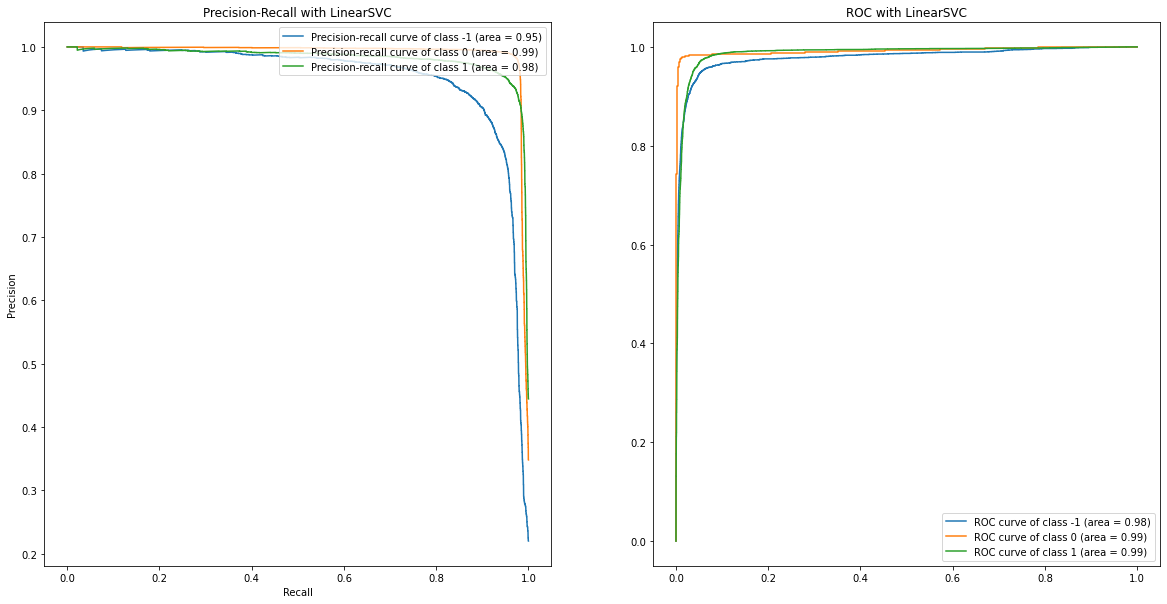

In [65]:
# Plot of precision-recall and ROC curves of our model

probs = clf.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], title='Precision-Recall with LinearSVC', y_v=y_test)
plot_ROC(probs, ax[1], title='ROC with LinearSVC', y_v=y_test)

We can see that all curves are so good for each label and in both types of curves.

### 6.3 Confusion matrix

Text(33.0, 0.5, 'True label')

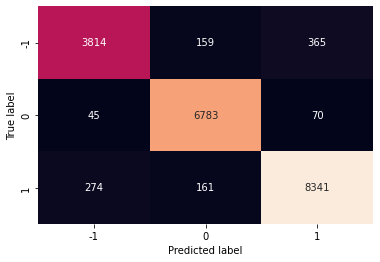

In [66]:
# Confusion matrix of our model

label_aux = plt.subplot()
pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, index=['-1','0', '1'], columns=['-1','0', '1'])
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
label_aux.set_xlabel('Predicted label'); label_aux.set_ylabel('True label')

Text(17.200000000000003, 0.5, 'True label')

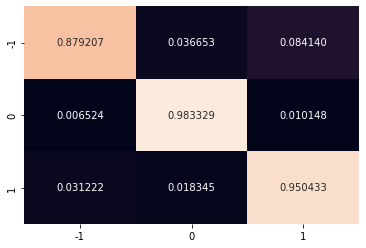

In [67]:
# Confusion matrix of proportions (#{samples with label l classified as ...}/#{samples with label l})

prop_cm_df = cm_df
prop_cm_df[0:1] /= (y_test == -1).sum()
prop_cm_df[1:2] /= (y_test == 0).sum()
prop_cm_df[2:3] /= (y_test == 1).sum()
sns.heatmap(prop_cm_df, annot=True, fmt="f", cbar=False)
label_aux.set_xlabel('Predicted label'); label_aux.set_ylabel('True label')

As it is logical, all samples are well classified. If we look at samples which had not been well classified, we can see that negative sentiment's samples are mainly confused with positive sentiment's samples and vice versa. Neutral sentiment's samples are, more or less, as confused with negative samples as with positive samples.

## 7. Conclusions

After creating and analyzing our classifier, we can conclude that it is possible to build a classificator of messages by sentiment based in Reddit and Twitter text messages.

We have reached so good accuracies. Furthermore, we have tested our classifier giving it some self-made text messages and it has classified our messages well. So we have checked by ourselves that it works properly.

## Extra

In [110]:
path = 'Cas_kaggle_extra/'

In [96]:
dill.dump_session(path + 'sentimental_analyisis.db')

In [111]:
# To save our classifier
joblib.dump(classifier, path + 'classifier.pkl')

['Cas_kaggle_extra/classifier.pkl']

In [107]:
# To save our auxiliar classifier
joblib.dump(clf, path + 'clf.pkl')

['Cas_kaggle_extra/clf.pkl']

In [108]:
# To save function classify()
with open(path + 'classify.pkl', 'wb') as f:
    dill.dump(classify, f)

In [109]:
# To save function predict()
with open(path + 'predict.pkl', 'wb') as f:
    dill.dump(predict, f)